In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import torch.nn.init as ini
import h5py
import random

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.first_layer_down_conv1 = nn.Conv3d(4, 8, 3, padding = 1)
        self.first_layer_down_bn1 = nn.BatchNorm3d(8)
        self.first_layer_down_pre1 = nn.PReLU()
        self.second_layer_down_conv1 = nn.Conv3d(8, 16, 3, padding = 1, stride = 2)
        self.second_layer_down_bn1 = nn.BatchNorm3d(16)
        self.second_layer_down_pre1 = nn.PReLU()
        self.second_layer_down_conv2 = nn.Conv3d(16, 16, 3, padding = 1)
        self.second_layer_down_bn2 = nn.BatchNorm3d(16)
        self.second_layer_down_pre2 = nn.PReLU()
        self.third_layer_down_conv1 = nn.Conv3d(16, 32, 3, padding = 1, stride = 2)
        self.third_layer_down_bn1 = nn.BatchNorm3d(32)
        self.third_layer_down_pre1 = nn.PReLU()
        self.third_layer_down_conv2 = nn.Conv3d(32, 32, 3, padding = 1)
        self.third_layer_down_bn2 = nn.BatchNorm3d(32)
        self.third_layer_down_pre2 = nn.PReLU()
        self.fourth_layer_down_conv1 = nn.Conv3d(32, 64, 3, padding = 1, stride = 2)
        self.fourth_layer_down_bn1 = nn.BatchNorm3d(64)
        self.fourth_layer_down_pre1 = nn.PReLU()
        self.fourth_layer_down_conv2 = nn.Conv3d(64, 64, 3, padding = 1)
        self.fourth_layer_up_conv1 = nn.Conv3d(64, 64, 1)
        self.fourth_layer_up_bn1 = nn.BatchNorm3d(64)
        self.fourth_layer_up_pre1 = nn.PReLU()
        self.fourth_layer_up_deconv = nn.ConvTranspose3d(64, 32, 3, padding = 1, output_padding = 1, stride = 2)
        self.fourth_layer_up_bn2 = nn.BatchNorm3d(32)
        self.fourth_layer_up_pre2 = nn.PReLU()
        self.third_layer_up_conv1 = nn.Conv3d(64, 64, 3, padding = 1)
        self.third_layer_up_bn1 = nn.BatchNorm3d(64)
        self.third_layer_up_pre1 = nn.PReLU()
        self.third_layer_up_conv2 = nn.Conv3d(64, 32, 1)
        self.third_layer_up_bn2 = nn.BatchNorm3d(32)
        self.third_layer_up_pre2 = nn.PReLU()
        self.third_layer_up_deconv = nn.ConvTranspose3d(32, 16, 3, padding = 1, output_padding = 1, stride = 2)
        self.third_layer_up_bn3 = nn.BatchNorm3d(16)
        self.third_layer_up_pre3 = nn.PReLU()
        self.second_layer_up_conv1 = nn.Conv3d(32, 32, 3, padding = 1)
        self.second_layer_up_bn1 = nn.BatchNorm3d(32)
        self.second_layer_up_pre1 = nn.PReLU()
        self.second_layer_up_conv2 = nn.Conv3d(32, 16, 1)
        self.second_layer_up_bn2 = nn.BatchNorm3d(16)
        self.second_layer_up_pre2 = nn.PReLU()
        self.second_layer_up_deconv = nn.ConvTranspose3d(16, 8, 3, padding = 1, output_padding = 1, stride = 2)
        self.second_layer_up_bn3 = nn.BatchNorm3d(8)
        self.second_layer_up_pre3 = nn.PReLU()
        self.first_layer_up_conv1 = nn.Conv3d(16, 16, 3, padding = 1)
        self.first_layer_up_bn1 = nn.BatchNorm3d(16)
        self.first_layer_up_pre1 = nn.PReLU()
        self.third_seg = nn.Conv3d(64, 5, 1)
        self.second_seg = nn.Conv3d(32, 5, 1)
        self.first_seg = nn.Conv3d(16, 5, 1)
        self.upsample_layer = nn.Upsample(scale_factor = 2, mode = 'trilinear')

    def forward(self, x):
        x = self.first_layer_down_conv1(x)
        x = self.first_layer_down_bn1(x)
        x = self.first_layer_down_pre1(x)
        first_layer_feature = x
        
        x = self.second_layer_down_conv1(x)
        temp = x
        x = self.second_layer_down_bn1(x)
        x = self.second_layer_down_pre1(x)
        x = self.second_layer_down_conv2(x)
        x = torch.add(x, temp)
        x = self.second_layer_down_bn2(x)
        x = self.second_layer_down_pre2(x)
        second_layer_feature = x
        
        x = self.third_layer_down_conv1(x)
        temp = x
        x = self.third_layer_down_bn1(x)
        x = self.third_layer_down_pre1(x)
        x = self.third_layer_down_conv2(x)
        x = torch.add(x, temp)
        x = self.third_layer_down_bn2(x)
        x = self.third_layer_down_pre2(x)
        third_layer_feature = x
        
        x = self.fourth_layer_down_conv1(x)
        temp = x
        x = self.fourth_layer_down_bn1(x)
        x = self.fourth_layer_down_pre1(x)
        x = self.fourth_layer_down_conv2(x)
        x = torch.add(x, temp)
        
        x = self.fourth_layer_up_conv1(x)
        x = self.fourth_layer_up_bn1(x)
        x = self.fourth_layer_up_pre1(x)
        x = self.fourth_layer_up_deconv(x)
        x = self.fourth_layer_up_bn2(x)
        x = self.fourth_layer_up_pre2(x)
        
        x = torch.cat((x, third_layer_feature), 1)
        x = self.third_layer_up_conv1(x)
        x = self.third_layer_up_bn1(x)
        x = self.third_layer_up_pre1(x)
        third_seg_map = self.third_seg(x)
        x = self.third_layer_up_conv2(x)
        x = self.third_layer_up_bn2(x)
        x = self.third_layer_up_pre2(x)
        x = self.third_layer_up_deconv(x)
        x = self.third_layer_up_bn3(x)
        x = self.third_layer_up_pre3(x)
        
        x = torch.cat((x, second_layer_feature), 1)
        x = self.second_layer_up_conv1(x)
        x = self.second_layer_up_bn1(x)
        x = self.second_layer_up_pre1(x)
        second_seg_map = self.second_seg(x)
        x = self.second_layer_up_conv2(x)
        x = self.second_layer_up_bn2(x)
        x = self.second_layer_up_pre2(x)
        x = self.second_layer_up_deconv(x)
        x = self.second_layer_up_bn3(x)
        x = self.second_layer_up_pre3(x)
        
        x = torch.cat((x, first_layer_feature), 1)
        x = self.first_layer_up_conv1(x)
        x = self.first_layer_up_bn1(x)
        x = self.first_layer_up_pre1(x)
        first_seg_map = self.first_seg(x)
        
        third_seg_map = self.upsample_layer(third_seg_map)
        second_seg_map = torch.add(third_seg_map, second_seg_map)
        second_seg_map = self.upsample_layer(second_seg_map)
        x = torch.add(first_seg_map, second_seg_map)
        return x
        
net = Unet()
net.cuda(1)
prev_time = time.clock()

for param in net.parameters():
    try:
        nout = param.size()[0]
        nin = param.size()[1]
        ini.normal(param.data, mean = 0, std = 0.01)
        param = param / ((2/(nin+nout))**0.5)
    except:
        pass



In [3]:
f = h5py.File('Unet-training.h5')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026"]

def create_train_batch(img = 0):
    case = SAMPLE[img]
    key0 = case[:2]
    key1 = case[3:]
    _, X, Y, Z = f[key0][key1].shape
    train_batch = [];
    train_label = [];
    x = random.randint(64, X-64)
    y = random.randint(64, Y-64)
    z = random.randint(48, Z-48)
    train_batch.append(f[key0][key1][0:4,x-64:x+64,y-64:y+64,z-48:z+48])
    train_label.append(f[key0][key1][4,x-64:x+64,y-64:y+64,z-48:z+48])
    train_batch = np.array(train_batch)
    train_label = np.array(train_label)
    train_batch = torch.from_numpy(train_batch)
    train_label = torch.from_numpy(train_label)
    train_label = torch.Tensor.long(train_label)
    return train_batch, train_label

def create_val():
    case = "HG/0001"
    key0 = case[:2]
    key1 = case[3:]
    _, X, Y, Z = f[key0][key1].shape
    val_batch = [];
    val_label = [];
    x = X//2
    y = Y//2
    z = Z//2
    val_batch.append(f[key0][key1][0:4,x-64:x+64,y-64:y+64,z-48:z+48])
    val_label.append(f[key0][key1][4,x-64:x+64,y-64:y+64,z-48:z+48])
    val_batch = np.array(val_batch)
    val_label = np.array(val_label)
    val_batch = torch.from_numpy(val_batch)
    val_label = torch.from_numpy(val_label)
    val_label = torch.Tensor.long(val_label)
    return val_batch, val_label

val_x, val_y = create_val()
val_x = Variable(val_x).cuda(1)
val_y = val_y.view(-1)
val_y = val_y.cuda(1)
y_pred = net.forward(val_x)

In [13]:
import matplotlib.pyplot as plt
net.load_state_dict(torch.load('unet39.txt'))
net.cuda(1)


Unet (
  (first_layer_down_conv1): Conv3d(4, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (first_layer_down_bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True)
  (first_layer_down_pre1): PReLU (1)
  (second_layer_down_conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (second_layer_down_bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
  (second_layer_down_pre1): PReLU (1)
  (second_layer_down_conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (second_layer_down_bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
  (second_layer_down_pre2): PReLU (1)
  (third_layer_down_conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (third_layer_down_bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
  (third_layer_down_pre1): PReLU (1)
  (third_layer_down_conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (third

fuck3


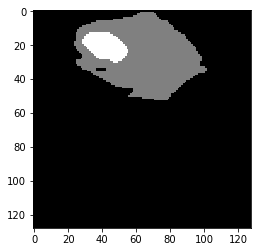

(1, 128, 128, 96)


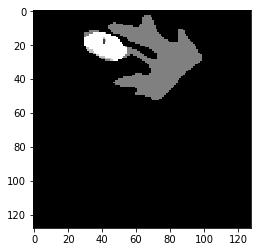

In [14]:
val_x, val_y = create_val()
val_x = Variable(val_x).cuda(1)
y_pred = net.forward(val_x)
y_pred = y_pred.view(5,-1)
_, y_pred = torch.max(y_pred, 0)
y_pred = y_pred.view(128,128,96)
array_image = y_pred.data.cpu().numpy()

plt.imshow(array_image[:,:,60], cmap = 'gray')
plt.show()
val_y = val_y.numpy()
print(val_y.shape)
plt.imshow(val_y[0,:,:,60], cmap = 'gray')
plt.show()

In [3]:
print(val_x.size(), val_y)
print(y_pred.size())

torch.Size([1, 4, 128, 128, 96]) 
 0
 0
 0
⋮ 
 0
 0
 0
[torch.cuda.LongTensor of size 1572864 (GPU 1)]

torch.Size([1, 5, 128, 128, 96])


In [4]:
net = net.cuda(1)
w = torch.Tensor([0.04/4, 0.998/4, 0.976/4, 0.995/4, 0.994/4])
w = w.cuda(1)
num_epoch = 200;

import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 5e-3, weight_decay = 5e-6)
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

for i in range(num_epoch):
    random.shuffle(SAMPLE)
    for j in range(len(SAMPLE)):
        train_batch, val_batch = create_train_batch(j)
        train_batch = Variable(train_batch).cuda(1)
        val_batch = Variable(val_batch).cuda(1)
        out = net.forward(train_batch)
        out = torch.transpose(out, 0, 1)
        out.contiguous()
        out = out.view(5, -1)
        out = torch.transpose(out, 0, 1)
        out.contiguous()
        val_batch = val_batch.view(-1)
        criterion = nn.CrossEntropyLoss(weight = w)
        loss = criterion(out, val_batch)
        optimizer.zero_grad()
        loss.backward()
        print(loss)
        
        optimizer.step()
        y_pred = net.forward(val_x)
        y_pred = y_pred.view(5, -1)
        y_pred = torch.transpose(y_pred, 0, 1)
        out.contiguous()
        _, y_pred = torch.max(y_pred.data, 1)
        correct = (y_pred == val_y).sum()
        print('Validation accuracy:', float(correct) / 128 / 128 / 96)
        print('time used:%.3f'% (time.clock() - prev_time))
    scheduler.step()

Variable containing:
 1.7351
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.03339385986328125
time used:8.496
Variable containing:
 1.3312
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.03982416788736979
time used:10.345
Variable containing:
 2.0159
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.6446940104166666
time used:12.206
Variable containing:
 1.6200
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.6697667439778646
time used:14.067
Variable containing:
 1.4280
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.6549530029296875
time used:15.940
Variable containing:
 1.4396
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.6136436462402344
time used:17.808
Variable containing:
 1.4731
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accuracy: 0.6773509979248047
time used:19.681
Variable containing:
 1.2379
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Validation accur

KeyboardInterrupt: 

In [ ]:
torch.save(net.state_dict(), "unet.txt")
print ("successfully saved!")